## Welcome, in this notebook I will present my end-of-course project for the Unsupervised Machine Learning course for the IBM Professional Certification in Machine Learning (https://www.coursera.org/professional-certificates/ibm-machine-learning)

The purpose is to solve a customer segmentation problem for a car sales company. The operations we will perform are:
* Data Cleaning;
* EDA and feature engineering;
* Clustering;
* Data analytics and insights.

The dataset I used can be found at https://www.kaggle.com/datasets/vetrirah/customer/data

The features are:

1. ID;
2. Gender;
3. Marital status of the customer;
4. Age;
5. If he is graduated;
6. Profession of the customer;
7. Work experience in years;
8. Spending score (low, medium/average, high)
9. Family size;
10. Anonymised category for the customer.





The first step is to download the dataset. To obtain a dataset from Kaggle, you can either download it through the web interface or use the APIs. To use the APIs, you need to have the 'kaggle' command installed and an access token, which will be a .json file that should be placed in the directory containing the 'kaggle' command (in my case, /root/.kaggle/)

As always, I recommend to use Google Colab instead of your machine to run ML application if you don't have GPU or a strong computation support.

In [2]:
# On Google Colab, it is already installed
# !pip install kaggle

!mv /content/kaggle.json /root/.kaggle/

Note: if this command give you an error such as "No such file or directory", try to exec the next command the first time(to download the dataset), then exec this again and than the command to download the dataset again

In [3]:
!kaggle datasets download -d vetrirah/customer

  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 94.1MB/s]


In [4]:
!unzip customer.zip

Archive:  customer.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: sample_submission.csv   


As we can see by downloading the dataset, we have a Train file and a Test file. With the training file, we can assess the effectiveness of our clustering algorithm, which, as requested by the challenge authors, should form 4 clusters (this simplifies our choice in the case of algorithms like K-Means, where a crucial aspect is choosing the number of clusters) that reflect as closely as possible their 'ideal' clustering of the dataset. The challenge is closed, so we cannot submit for the test set.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_rows', 50)
import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_csv("/content/Train.csv")
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


Columns need encoding

In [7]:
data.select_dtypes(include='object').drop(axis=1, columns=['Segmentation']).loc[0].keys()
# data.select_dtypes(include='object').columns

Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1'],
      dtype='object')

## Data Cleaning

In [8]:
# Drop ID column
data.drop(columns = ['ID'] , inplace = True)

In [9]:
# Check null values
data.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In my opinion, the best operations for semplicity are:
* Drop every rows with null value in __Profession__ and __Var_1__;
* Fill null value with 'No' for __married__ and __graduated__ informations;
* Set __work experience__ and __family size__ to minimum.


In [10]:
# Drop the values which has null in profession column
data.dropna(subset = ['Profession','Var_1'] , inplace = True)

# Fill null values
data['Ever_Married'] = data['Ever_Married'].fillna('No')
data['Graduated'] = data['Graduated'].fillna('No')
data['Work_Experience'] = data['Work_Experience'].fillna(0)
data['Family_Size'] = data['Family_Size'].fillna(1)

In [11]:
# Save ideal clusters
segmentation = data['Segmentation']

# Drop unused columns
data.drop(columns = ['Segmentation'] , inplace = True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7871 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           7871 non-null   object 
 1   Ever_Married     7871 non-null   object 
 2   Age              7871 non-null   int64  
 3   Graduated        7871 non-null   object 
 4   Profession       7871 non-null   object 
 5   Work_Experience  7871 non-null   float64
 6   Spending_Score   7871 non-null   object 
 7   Family_Size      7871 non-null   float64
 8   Var_1            7871 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 614.9+ KB


## EDA

#### Categorical Feature

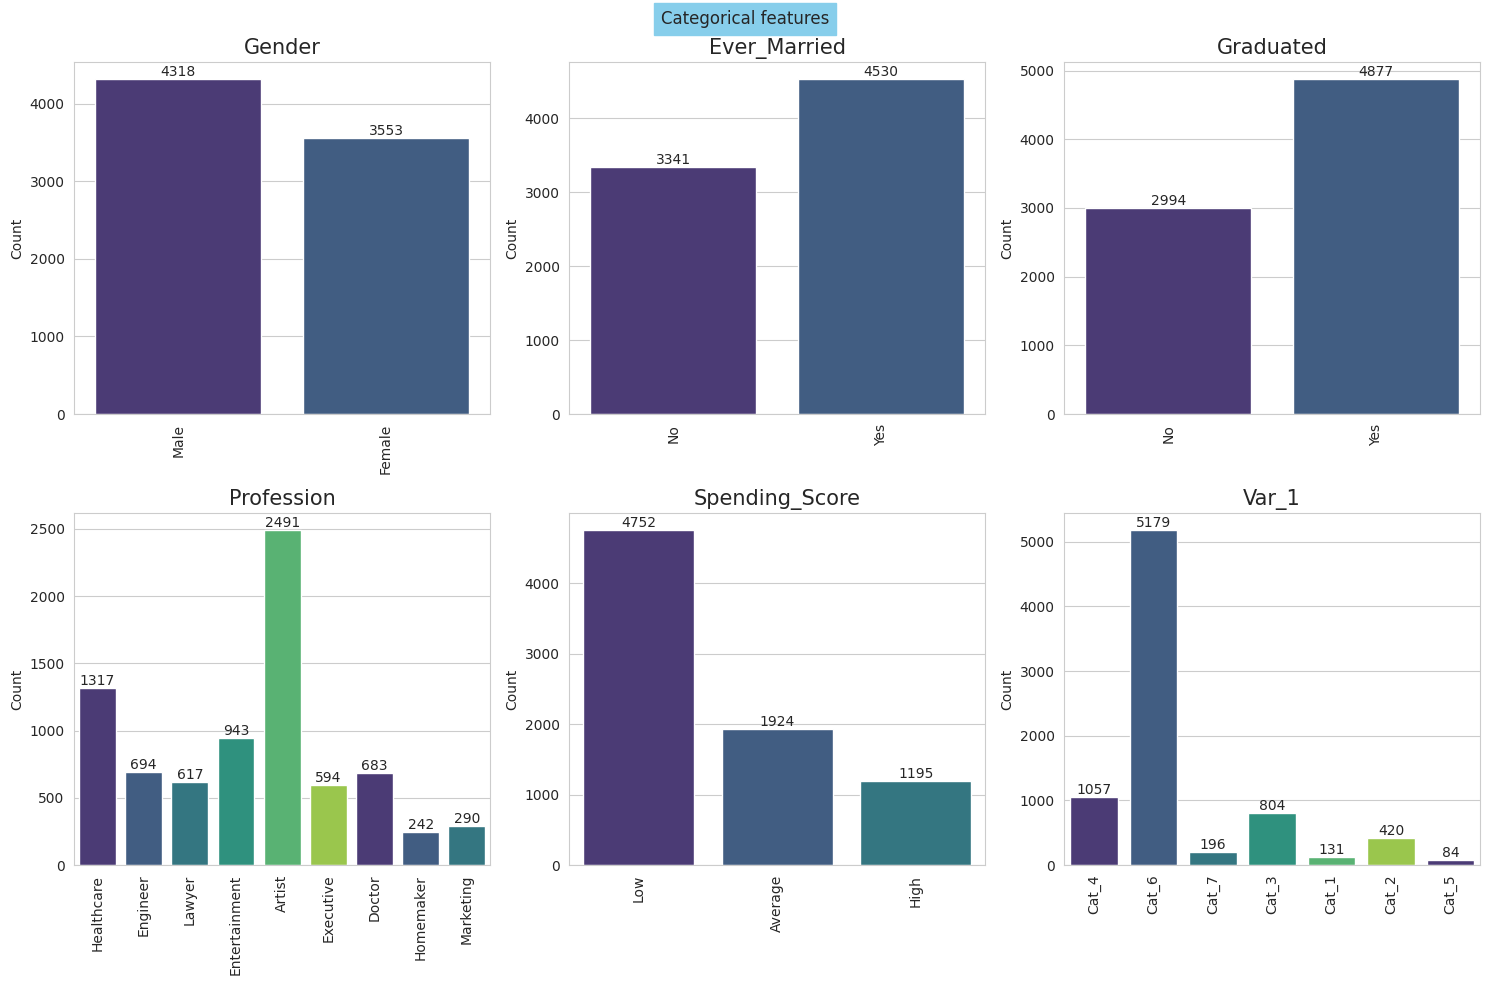

In [12]:
# Exploring categorical features
data_cat = data.select_dtypes('object')
fig = plt.figure(figsize = (15,10))
plt.suptitle('Categorical features', backgroundcolor = 'skyblue')

for i,j in enumerate(data_cat.columns):
    ax = fig.add_subplot(2,3,i+1)
    ax = sns.countplot(data, x = j, palette = sns.color_palette('viridis'))
    ax.set_title(j, fontsize = 15)
    ax.set_xticklabels(labels = data[j].unique(), rotation = 90)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.bar_label(ax.containers[0],label_type='edge')

plt.tight_layout()

#### Numerical Features

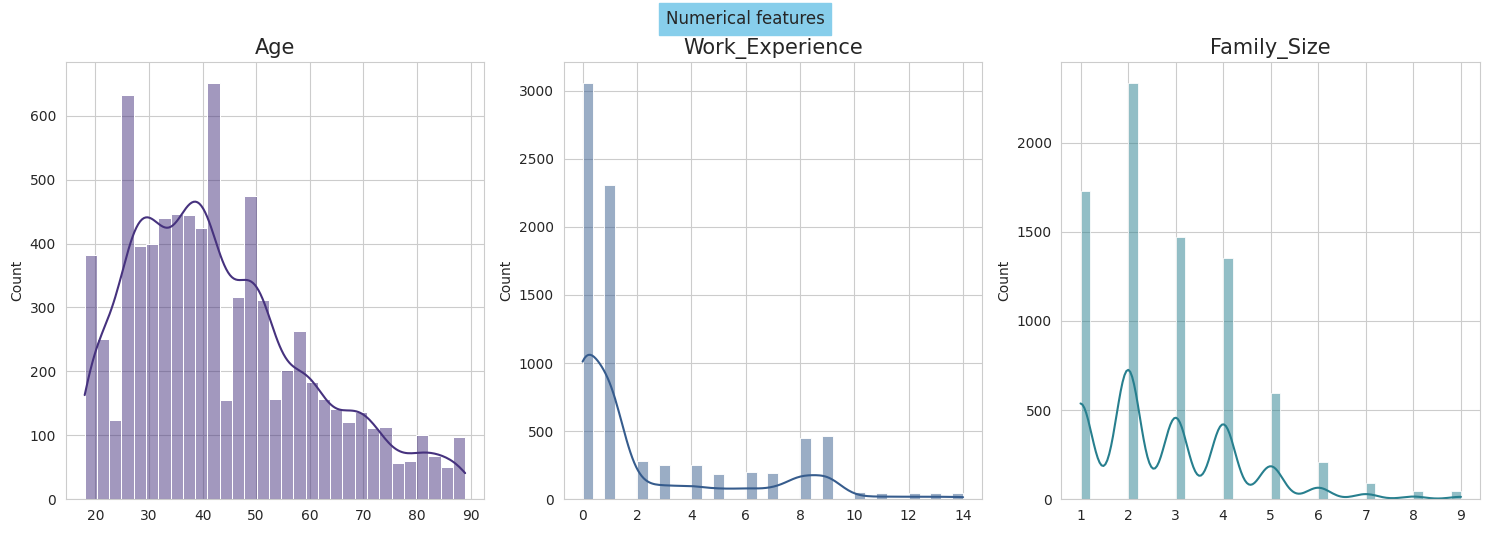

In [13]:
data_num = data.select_dtypes(['float64','int64'])
fig = plt.figure(figsize = (15,10))
plt.suptitle('Numerical features', backgroundcolor = 'skyblue')
colors = sns.color_palette('viridis')

for i,j in enumerate(data_num.columns):
    ax = fig.add_subplot(2,3,i+1)
    ax = sns.histplot(data , x = j, kde = True, color = colors[i])
    ax.set_title(j , fontsize = 15)
    ax.set_ylabel('Count')
    ax.set_xlabel('')

plt.tight_layout()

## Feature Engineering

The processing in this case is simple. We have two type of operation to perform:
* One-hot encoding of Profession and Var_1 columns;
* Ordinal encoding of Spending_Score column;
* Binary encoding of all the other categorical columns;
* Min-Max scaling of numerical features.

In [14]:
df = data.copy()

In [15]:
from sklearn.preprocessing import MinMaxScaler

df = pd.get_dummies(df, columns=['Profession', 'Var_1'], prefix='', prefix_sep='')

spending_score_encoding = {'Low': 0, 'Average': 1, 'High': 2}
df['Spending_Score'] = df['Spending_Score'].map(spending_score_encoding)

gender_encoding = {'Female': 0, 'Male': 1}
df['Gender'] = df['Gender'].map(gender_encoding)

married_encoding = {'No': 0, 'Yes': 1}
df['Ever_Married'] = df['Ever_Married'].map(married_encoding)

graduated_encoding = {'No': 0, 'Yes': 1}
df['Graduated'] = df['Graduated'].map(graduated_encoding)

mm_scaler = MinMaxScaler()
df[['Age', 'Work_Experience', 'Family_Size']] = mm_scaler.fit_transform(df[['Age', 'Work_Experience', 'Family_Size']])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7871 entries, 0 to 8067
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           7871 non-null   int64  
 1   Ever_Married     7871 non-null   int64  
 2   Age              7871 non-null   float64
 3   Graduated        7871 non-null   int64  
 4   Work_Experience  7871 non-null   float64
 5   Spending_Score   7871 non-null   int64  
 6   Family_Size      7871 non-null   float64
 7   Artist           7871 non-null   uint8  
 8   Doctor           7871 non-null   uint8  
 9   Engineer         7871 non-null   uint8  
 10  Entertainment    7871 non-null   uint8  
 11  Executive        7871 non-null   uint8  
 12  Healthcare       7871 non-null   uint8  
 13  Homemaker        7871 non-null   uint8  
 14  Lawyer           7871 non-null   uint8  
 15  Marketing        7871 non-null   uint8  
 16  Cat_1            7871 non-null   uint8  
 17  Cat_2         

## Clustering

We will use:
* K-Means;
* K-Means with PCA;
* Gaussian Mixture Models;
* Autoencoders (In a simplified manner)

In [17]:
df = pd.concat([df, segmentation], axis=1)

In [ ]:
df.reset_index(drop = True)

#### K-Means

A basic version of K-Means

In [19]:
from sklearn.cluster import KMeans

features = df.drop(columns=['Segmentation']).copy()

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(features)

#### K-Means with PCA

First PCA for dimensionality reduction, than K-means for clustering

In [20]:
from sklearn.decomposition import PCA

df_PCA = df.drop(columns=['Segmentation']).copy()

pca = PCA()
pca.fit(df_PCA)
df_PCA = pca.transform(df_PCA)

In [21]:
data_PCA = pd.DataFrame(columns=[f'Projection on Component {i+1}' for i in range(len(df.columns)-1)], data=df_PCA)
data_PCA.head()

,Projection on Component 1,Projection on Component 2,Projection on Component 3,Projection on Component 4,Projection on Component 5,Projection on Component 6,Projection on Component 7,Projection on Component 8,Projection on Component 9,Projection on Component 10,...,Projection on Component 14,Projection on Component 15,Projection on Component 16,Projection on Component 17,Projection on Component 18,Projection on Component 19,Projection on Component 20,Projection on Component 21,Projection on Component 22,Projection on Component 23
0,-1.132876,1.040616,-0.132097,0.435354,0.546095,0.046249,-0.557778,-0.245512,-0.228148,0.125206,...,0.017160,-0.022671,-0.068178,-0.006907,-0.013662,-0.011903,0.015227,-0.009801,-1.792251e-16,4.115972e-17
1,0.432149,0.552506,1.097582,0.025219,-0.431627,0.103798,-0.787390,-0.198606,-0.002687,-0.554988,...,-0.079192,0.020980,-0.069691,-0.007895,-0.024773,0.022197,0.122353,-0.005649,1.954752e-16,4.115972e-17
2,-0.144590,-0.495557,0.295522,-0.516846,-0.799007,-0.199501,-0.185573,-0.442738,0.011639,-0.718246,...,-0.124763,-0.064950,-0.047579,0.064691,-0.156642,-0.051440,-0.171891,-0.001820,3.897642e-16,-1.531293e-16
3,1.635097,0.180782,-0.474429,-0.200798,-0.174596,0.378225,-0.042819,-0.422798,0.065928,0.543790,...,0.152415,0.039064,0.008512,-0.009700,0.084737,0.053313,0.203474,0.007081,-6.302532e-16,1.340414e-17
4,1.409549,0.173353,0.149146,-0.615853,-0.372319,0.547188,-0.016271,0.697462,-0.587520,0.022100,...,-0.241705,0.086722,0.098518,-0.159063,0.238882,0.011137,0.040520,-0.012494,1.538418e-16,-8.374037e-17


In [22]:
import pandas as pd
from sklearn.decomposition import PCA

# Variance explained by every component
explained_variance_ratio = pca.explained_variance_ratio_

df_explained_variance = pd.DataFrame({
    'Component': [f'Component {i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance': explained_variance_ratio * 100
})

pd.options.display.float_format = '{:.3f}'.format

print(df_explained_variance)

       Component  Explained Variance
0    Component 1              26.473
1    Component 2              13.298
2    Component 3               9.833
3    Component 4               8.715
4    Component 5               6.016
5    Component 6               5.518
6    Component 7               4.106
7    Component 8               3.787
8    Component 9               3.578
9   Component 10               3.021
10  Component 11               2.827
11  Component 12               2.269
12  Component 13               2.246
13  Component 14               2.007
14  Component 15               1.405
15  Component 16               1.125
16  Component 17               1.079
17  Component 18               1.005
18  Component 19               0.677
19  Component 20               0.598
20  Component 21               0.420
21  Component 22               0.000
22  Component 23               0.000


In [23]:
# Low variance component filtering

df_variance = pd.DataFrame({
    'num_components_preserved': [i for i in range(23)],
    'variance': [df_explained_variance['Explained Variance'].iloc[:i].sum() for i in range(23)]
})

print(df_variance.iloc[::-1])

    num_components_preserved  variance
22                        22   100.000
21                        21   100.000
20                        20    99.580
19                        19    98.983
18                        18    98.306
17                        17    97.300
16                        16    96.222
15                        15    95.097
14                        14    93.692
13                        13    91.685
12                        12    89.440
11                        11    87.171
10                        10    84.344
9                          9    81.323
8                          8    77.746
7                          7    73.958
6                          6    69.853
5                          5    64.334
4                          4    58.318
3                          3    49.603
2                          2    39.771
1                          1    26.473
0                          0     0.000


In my opinion, preserving 15 out of 23 is a good choice, because we can preserve the 95% of total variance with 8 components less.

In [24]:
from sklearn.cluster import KMeans

features = data_PCA[data_PCA.columns[:15]].copy()

num_clusters = 4
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_pca_clusters = kmeans_pca.fit_predict(features)

#### Gaussian Mixture Model

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

df_GMM = df.drop(columns=['Segmentation']).copy()

# Previously we used the Min Max scaler to scale the numeric values.
# With the Gaussian mixture it is convenient to have numerical values ​​with normal trend

scaled_columns = ['Age', 'Work_Experience', 'Family_Size']

for column in scaled_columns:

  min_val = df[column].min()
  max_val = df[column].max()

  # Inverse formula
  original_data = df_GMM[column] * (max_val - min_val) + min_val

  df_GMM[column] = original_data


std_scaler = StandardScaler()
df_GMM[['Age', 'Work_Experience', 'Family_Size']] = std_scaler.fit_transform(df[['Age', 'Work_Experience', 'Family_Size']])


num_clusters = 4
gmm = GaussianMixture(n_components=num_clusters, covariance_type='spherical',random_state=42)
gmm_clusters = gmm.fit_predict(df_GMM)

#### Autoncoders

Basically we use autoencoders to extract latent representation of data, than K-Means to form clusters.

In [26]:
import tensorflow as tf

input_dim = len(df.columns) - 1
encoding_dim = 5  # Dimension of the latent space
features = df.drop(columns=['Segmentation']).copy()

# Encoder
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(encoding_dim, activation='relu')
], name='encoder')

# Decoder
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(encoding_dim,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='sigmoid')
], name='decoder')

# Autoencoder
autoencoder = tf.keras.models.Sequential([
    encoder,
    decoder
])

autoencoder.compile(optimizer='adam', loss='mse')

# Training
autoencoder.fit(features, features, epochs=50, batch_size=32, shuffle=True)

# Latent representation extraction
latent_representation = encoder.predict(features)

# Clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
autoencoder_clusters = kmeans.fit_predict(latent_representation)

Epoch 1/50
246/246 [==============================] - 2s 2ms/step - loss: 0.0964
Epoch 2/50
246/246 [==============================] - 1s 3ms/step - loss: 0.0463
Epoch 3/50
246/246 [==============================] - 1s 3ms/step - loss: 0.0337
Epoch 4/50
246/246 [==============================] - 1s 3ms/step - loss: 0.0283
Epoch 5/50
246/246 [==============================] - 1s 3ms/step - loss: 0.0254
Epoch 6/50
246/246 [==============================] - 1s 3ms/step - loss: 0.0237
Epoch 7/50
246/246 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 8/50
246/246 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 9/50
246/246 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 10/50
246/246 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 11/50
246/246 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 12/50
246/246 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 13/50
246/246 [====

In [27]:
# Save clusters
df['K-Means_Cluster'] = kmeans_clusters
df['K-Means_PCA_Cluster'] = kmeans_pca_clusters
df['GMM_clusters'] = gmm_clusters
df['Autoencoder_Cluster'] = autoencoder_clusters

In [29]:
df[df.columns[23:28]].head()

,Segmentation,K-Means_Cluster,K-Means__PCA_Cluster,GMM_clusters,Autoencoder_Cluster
0,D,3,1,0,2
1,A,2,3,2,2
2,B,2,3,1,0
3,B,1,0,1,3
4,A,1,0,0,1


In [31]:
seg_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
df['Segmentation'] = df['Segmentation'].map(seg_dict)

In [32]:
df[df.columns[23:28]].head()

,Segmentation,K-Means_Cluster,K-Means__PCA_Cluster,GMM_clusters,Autoencoder_Cluster
0,3,3,1,0,2
1,0,2,3,2,2
2,1,2,3,1,0
3,1,1,0,1,3
4,0,1,0,0,1


The numerical values in each column are independent of those in others; for example, when comparing the clusters formed with k-means and those formed with PCA and k-means, a correspondence can be observed. Specifically, cluster 3 in k-means corresponds to cluster 1 in k-means-PCA, cluster 2 in k-means corresponds to cluster 3 in k-means-PCA, cluster 1 in k-means corresponds to cluster 0 in k-means-PCA, and by exclusion, cluster 0 in k-means corresponds to cluster 2 in k-means-PCA. Instead of reasoning about the numbers to find the correct mapping, it is simpler to visually check which model has produced clusters more similar to the ideal ones.

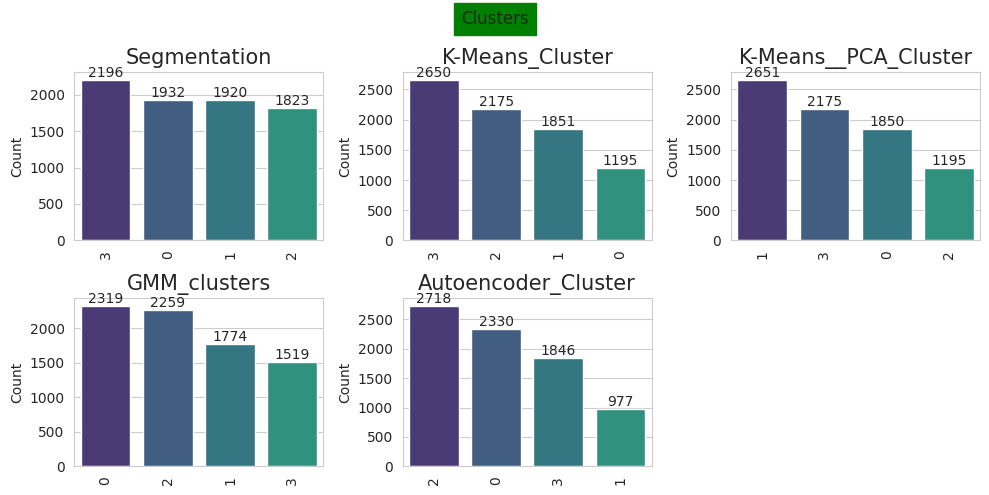

In [38]:
data_clusters = df[df.columns[23:28]]
fig = plt.figure(figsize = (10,5))
plt.suptitle('Clusters', backgroundcolor = 'green')

for i,j in enumerate(data_clusters.columns):

    value_counts = data_clusters[j].value_counts()
    sorted_values = value_counts.index

    ax = fig.add_subplot(2,3,i+1)
    ax = sns.countplot(data_clusters, x = j, order=sorted_values, palette = sns.color_palette('viridis'))
    ax.set_title(j, fontsize = 15)
    ax.set_xticklabels(labels = data_clusters[j].unique(), rotation = 90)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.bar_label(ax.containers[0],label_type='edge')

plt.tight_layout()

The best one is the GMM model, while the worst is the autoencoder. In my opinion, the autoencoder is too simple, plus taking a latent space with such low dimensionality has messed up a lot. A good exercise would be to find the optimal autoencoder structure for the task in question.


That's all, see you!